## EDA

The data source for this analysis is database MIMIC-III  (Medical Information Mart for Intensive Care III) developed by MIT.   The database also provides different kind of records of approximately 49,000 patients admitted to Beth Israel Deaconess Medical Center Intensive Care Unit (ICU) recorded between 2001 and 2012.   The records from this database contain demographic characteristics such as age, gender, religion, language and ethnicity.  In the database are also the records of diagnoses, events and test results, originated by patients during their stay in the ICU.

In [1]:
import numpy as np
import pandas as pd
import datetime
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import psycopg2
import time
import itertools
from pandas.io.sql import read_sql
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix


Given the limitations of the hardware, I was forced to restrict the data for the analysis (the detail of how the data selection was made will be explained below).  
The intensive care unit is a department of the hospitals where people treat life-threatening and require continuous monitoring of doctors, nurses and specialized equipment to monitor your condition and try to prevent his death .
The MIMIC III database used for this study contains the historical records of 58,976 admissions to the ICU of the Beth Israel Deaconess Medical Center between 2001 and 2012.  There were 46,520 people  admitted in total to this ICU during this period.  From this people, there are 1,424 who were admitted several times, but lately they died 


In [2]:
conn=psycopg2.connect(
    dbname='mimic',
    user='postgres',
    host='localhost',
    port=5432,
    password= 123
)
cur = conn.cursor()
process = time.process_time()
print (process)

3.328125


In [3]:
sql_ea = "select distinct subject_ID, gender, hospital_expire_flag,last_admit_age, age_group from mimiciii.pneumonia"

patients_ea= read_sql(sql_ea, conn, coerce_float=True, params=None)
print (patients_ea.info())
process = time.process_time()
print (process)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
subject_id              829 non-null int64
gender                  829 non-null object
hospital_expire_flag    829 non-null int64
last_admit_age          829 non-null float64
age_group               829 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 32.5+ KB
None
3.765625


In [4]:
patients_ea.head()

,subject_id,gender,hospital_expire_flag,last_admit_age,age_group
0,59777,F,0,67.23,elderly
1,54904,F,0,24.32,adult
2,59373,M,0,33.77,adult
3,65176,M,0,35.63,adult
4,55935,F,1,58.33,adult


In [5]:
row_index = patients_ea.last_admit_age >= 300
patients_ea.loc[row_index , 'last_admit_age' ] = 91.4  #https://mimic.physionet.org/mimictables/patients/

In [6]:
patients_ea.head(30)

,subject_id,gender,hospital_expire_flag,last_admit_age,age_group
0,59777,F,0,67.23,elderly
1,54904,F,0,24.32,adult
2,59373,M,0,33.77,adult
3,65176,M,0,35.63,adult
4,55935,F,1,58.33,adult
5,1754,F,0,51.13,adult
6,95280,F,1,85.43,oldest old
7,83920,F,0,45.71,adult
8,68235,F,0,53.26,adult
9,72107,M,0,83.42,elderly


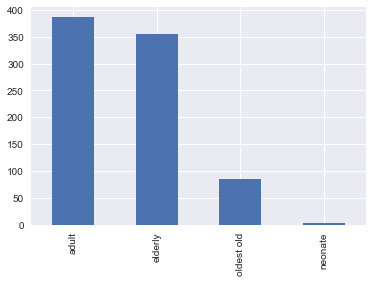

In [7]:
patients_ea.age_group.value_counts().plot(kind='bar')

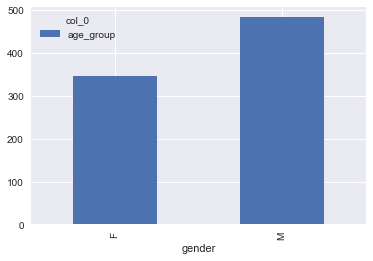

In [8]:
gender_tab = pd.crosstab(index = patients_ea["gender"],  # Make a crosstab
                              columns="age_group")      # Name the count column

gender_tab.plot.bar()

In [9]:
print ('summary', gender_tab.sum(), "\n")   # Sum the counts

print ('shape', gender_tab.shape, "\n")   # Check number of rows and cols

gender_tab.iloc[:]          # Slice rows 1-6

summary col_0
age_group    829
dtype: int64 

shape (2, 1) 



col_0,age_group
gender,
F,346
M,483


In [10]:
gender_tab/gender_tab.sum()

col_0,age_group
gender,
F,0.41737
M,0.58263


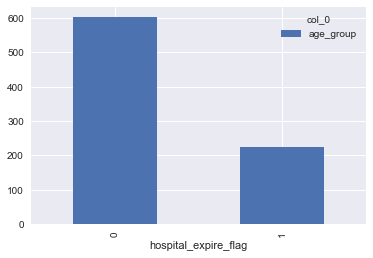

In [11]:
desease_tab = pd.crosstab(index = patients_ea["hospital_expire_flag"],  # Make a crosstab
                              columns="age_group")      # Name the count column

desease_tab.plot.bar()

In [12]:
print ('summary', desease_tab.sum(), "\n")   # Sum the counts

print ('shape', desease_tab.shape, "\n")   # Check number of rows and cols

desease_tab.iloc[:]    

summary col_0
age_group    829
dtype: int64 

shape (2, 1) 



col_0,age_group
hospital_expire_flag,
0,603
1,226


In [13]:
desease_tab/desease_tab.sum()

col_0,age_group
hospital_expire_flag,
0,0.727382
1,0.272618


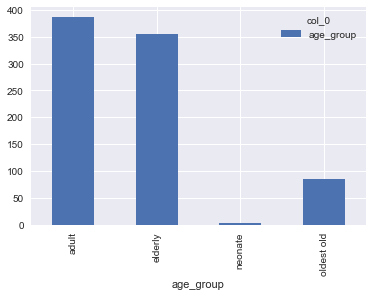

In [14]:
age_group_tab = pd.crosstab(index = patients_ea["age_group"],  # Make a crosstab
                              columns="age_group")      # Name the count column

age_group_tab.plot.bar()

In [15]:
print ('summary', age_group_tab.sum(), "\n")   # Sum the counts

print ('shape', age_group_tab.shape, "\n")   # Check number of rows and cols

gender_tab.iloc[:]          # Slice rows 1-6

summary col_0
age_group    829
dtype: int64 

shape (4, 1) 



col_0,age_group
gender,
F,346
M,483


In [16]:
age_group_tab

col_0,age_group
age_group,
adult,386
elderly,356
neonate,3
oldest old,84


In [17]:

age_group_tab/age_group_tab.sum()

col_0,age_group
age_group,
adult,0.465621
elderly,0.429433
neonate,0.003619
oldest old,0.101327


In [18]:
patients_ea.query('last_admit_age > 0  and last_admit_age <= 18') 

,subject_id,gender,hospital_expire_flag,last_admit_age,age_group


In [19]:
patients_ea.query('last_admit_age > 18  and last_admit_age <= 21') 

,subject_id,gender,hospital_expire_flag,last_admit_age,age_group
23,1003,M,0,20.79,adult
55,87119,M,0,19.64,adult
119,3158,M,0,20.10,adult
216,47591,M,0,18.48,adult
325,60139,F,0,19.64,adult
411,2111,M,0,18.95,adult
558,2317,M,0,20.64,adult
594,5881,F,0,19.68,adult
603,96562,M,0,19.17,adult
769,82309,M,0,20.66,adult


In [20]:
patients_ea.query('last_admit_age > 18  and last_admit_age <= 21').count()

subject_id              11
gender                  11
hospital_expire_flag    11
last_admit_age          11
age_group               11
dtype: int64

In [21]:
patients_ea.query('last_admit_age > 0  and last_admit_age <= 18') .count()

subject_id              0
gender                  0
hospital_expire_flag    0
last_admit_age          0
age_group               0
dtype: int64

In [22]:
patients_ea["gender"] = patients_ea["gender"] .astype('category')
patients_ea["age_group"] = patients_ea["age_group"] .astype('category')
patients_ea["hospital_expire_flag"] = patients_ea["hospital_expire_flag"] .astype('category')

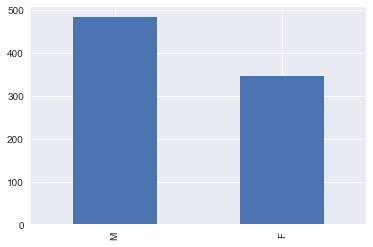

In [23]:
patients_ea.gender.value_counts().plot(kind='bar')

In [24]:
patients_ea.gender.value_counts()

M    483
F    346
Name: gender, dtype: int64

In [25]:
n_sample = patients_ea.subject_id.count() 

Masculine, Femenine = patients_ea.gender.value_counts()
print ('Masculine % {0} %\n'.format(Masculine / n_sample * 100.00))
print ('Femenine % {0} %\n'.format(Femenine / n_sample * 100.00))

Masculine % 58.26296743063932 %

Femenine % 41.73703256936068 %



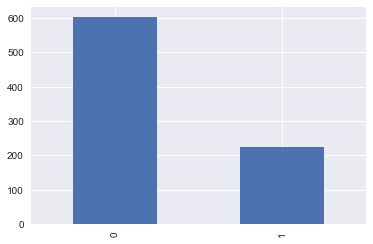

In [26]:
patients_ea.hospital_expire_flag.value_counts().plot(kind='bar')

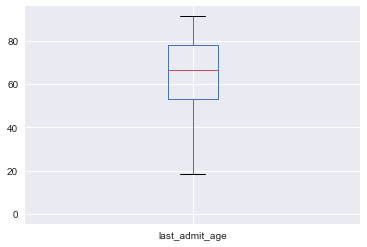

In [27]:
patients_ea['last_admit_age'].plot.box()

In [28]:
patients_ea['last_admit_age'].describe()

count    829.000000
mean      64.200651
std       17.736999
min        0.000000
25%       53.110000
50%       66.550000
75%       78.210000
max       91.400000
Name: last_admit_age, dtype: float64

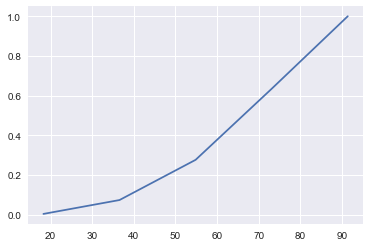

In [29]:
H,X1 = np.histogram( patients_ea['last_admit_age'], bins = 5, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx


plt.plot(X1[1:], F1)
plt.show()

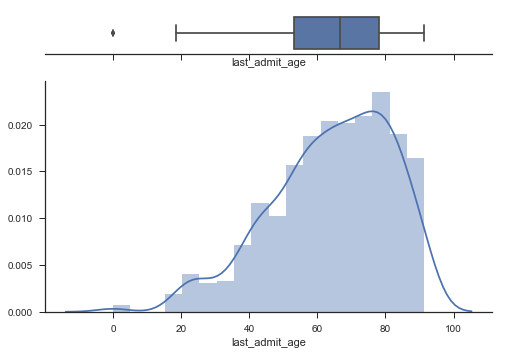

In [30]:
sns.set(style="ticks")

x = patients_ea['last_admit_age']

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)


ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

count    829.000000
mean      64.200651
std       17.736999
min        0.000000
25%       53.110000
50%       66.550000
75%       78.210000
max       91.400000
Name: last_admit_age, dtype: float64
Average Age of Patients with Pneumonia 17.7369988668
Maximum Age of Patients with Pneumonia 91.4
Minimum Age of Patients with Pneumonia  0.0
Standard Deviation Age of Patients with Pneumonia  17.7369988668


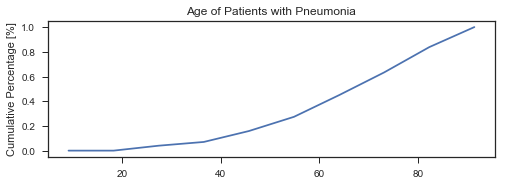

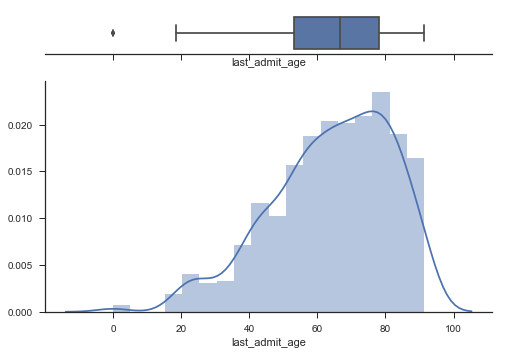

In [31]:
plt.subplot(212)
H,X1 = np.histogram( patients_ea['last_admit_age'], bins = 10, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx


plt.plot(X1[1:], F1)
plt.ylabel('Cumulative Percentage [%]')
plt.title('Age of Patients with Pneumonia')


sns.set(style="ticks")

print(x.describe())

x = patients_ea['last_admit_age']
mean_x = patients_ea['last_admit_age'].mean()
max_x = mean_x = patients_ea['last_admit_age'].max()
min_x = mean_x = patients_ea['last_admit_age'].min()
sd_x = mean_x = patients_ea['last_admit_age'].std()

print ("Average Age of Patients with Pneumonia", mean_x)
print ("Maximum Age of Patients with Pneumonia", max_x)
print ("Minimum Age of Patients with Pneumonia ", min_x)
print ("Standard Deviation Age of Patients with Pneumonia ", sd_x)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()

The adult population is 46.6% or 386 persons, followed by elderly group which has 42.9% or 356 and oldest old group with 10.1% or 84 persons, and as I said above, the middle group doesn’t have any person, and the neonate population is represented by 0.4% or 3 persons.   The sample consists of 42% women and 58% men, it is 346 and 483 persons respectively.   

The sample has a mean of 64.20 years and a standard deviation of 17.74 years, where the 75% has more than 53 years, this is showing more vulnerable population with pneumonia in ICU is a middle age person or older.  The above empirical distribution is showing a negative asymmetry with shape skewed to left side

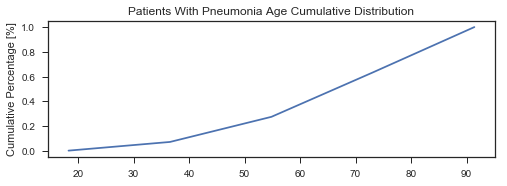

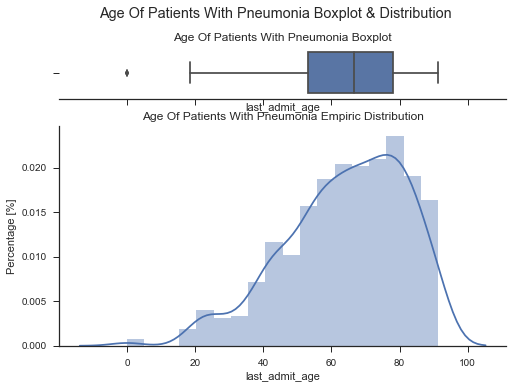

In [32]:
plt.subplot(211)
H,X1 = np.histogram( patients_ea['last_admit_age'], bins = 5, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx


plt.plot(X1[1:], F1)
plt.ylabel('Cumulative Percentage [%]')
plt.title('Patients With Pneumonia Age Cumulative Distribution')


sns.set(style="ticks")

x = patients_ea['last_admit_age']

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.2, .85)})

plt.suptitle('Age Of Patients With Pneumonia Boxplot & Distribution')
plt.ylabel('Percentage [%]')


sns.boxplot(x, ax=ax_box).set_title('Age Of Patients With Pneumonia Boxplot')
sns.distplot(x, ax=ax_hist).set_title('Age Of Patients With Pneumonia Empiric Distribution')


sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)


plt.show()

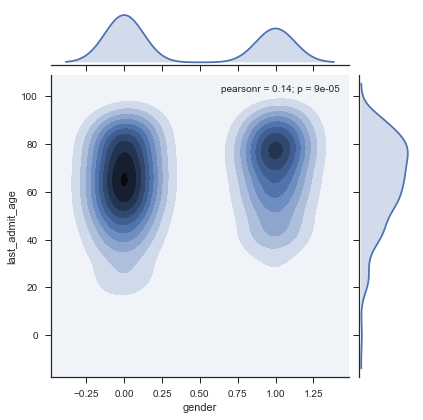

In [33]:
p_map = {'M':0,'F':1}

patients_map = patients_ea.applymap(lambda s: p_map.get(s) if s in p_map else s)

sns.jointplot(x="gender", y="last_admit_age", data=patients_map, kind="kde");

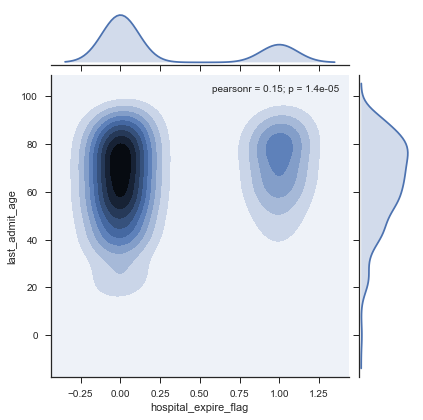

In [34]:
sns.jointplot(x="hospital_expire_flag", y="last_admit_age", data=patients_map, kind="kde");

the bivariate distributions between age (last_admit_age) and gender, and age (last_admit_age) and decease (hospital_expire_flag).  The left graph, show the gender distribution (Masculine = 0, Feminine = 1) vs. age. This graph shows a higher dispersion in men, and higher concentration in women, it is interesting, is that men are more prone to acquire acute pneumonia being admitted the ICU.   The following graph shows the relationship between age and deaths (Alive = 0, Deceased = 1), showing a similar distribution, but in this case the people most likely to die in the ICU are those who are in the elderly group.

The neonate group of patients has no deaths in this sample, all of deaths in this sample are more related to adult people, with higher concentration in people that are 60 years or older.  This relationship must be collected by the model given the assumptions formulated by the hypothesis.

In [35]:
patients_ea['Quantity'] = 1 
patients_ea.head(20)

,subject_id,gender,hospital_expire_flag,last_admit_age,age_group,Quantity
0,59777,F,0,67.23,elderly,1
1,54904,F,0,24.32,adult,1
2,59373,M,0,33.77,adult,1
3,65176,M,0,35.63,adult,1
4,55935,F,1,58.33,adult,1
5,1754,F,0,51.13,adult,1
6,95280,F,1,85.43,oldest old,1
7,83920,F,0,45.71,adult,1
8,68235,F,0,53.26,adult,1
9,72107,M,0,83.42,elderly,1


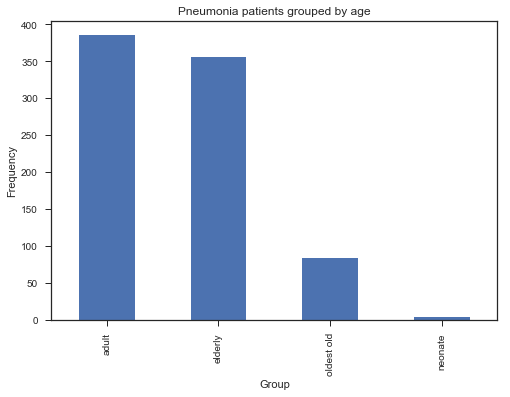

In [36]:
ax = patients_ea.age_group.value_counts().plot(kind='bar')

ax.set_ylabel('Frequency')
ax.set_xlabel('Group')

ax.set_title('Pneumonia patients grouped by age')

plt.show()

In [37]:
patients_pv = patients_ea.iloc[:,1:6]

In [38]:
patients_pv.head(10)

,gender,hospital_expire_flag,last_admit_age,age_group,Quantity
0,F,0,67.23,elderly,1
1,F,0,24.32,adult,1
2,M,0,33.77,adult,1
3,M,0,35.63,adult,1
4,F,1,58.33,adult,1
5,F,0,51.13,adult,1
6,F,1,85.43,oldest old,1
7,F,0,45.71,adult,1
8,F,0,53.26,adult,1
9,M,0,83.42,elderly,1


In [39]:
patients_pv["gender"] = patients_ea["gender"] .astype('category')
patients_pv["age_group"] = patients_ea["age_group"] .astype('category')
patients_pv["hospital_expire_flag"] = patients_ea["hospital_expire_flag"] .astype('category')

In [40]:
pd.pivot_table(patients_pv,index=["gender", "age_group","hospital_expire_flag"], 
               values=["Quantity"],aggfunc=np.sum, fill_value=0)

Quantity
gender age_group  hospital_expire_flag          
F      adult      0                          104
                  1                           31
       elderly    0                          109
                  1                           54
       neonate    0                            1
                  1                            0
       oldest old 0                           34
                  1                           13
M      adult      0                          197
                  1                           54
       elderly    0                          134
                  1                           59
       neonate    0                            2
                  1                            0
       oldest old 0                           22
                  1                           15

In [41]:
pd.pivot_table(patients_pv,index=["gender", "hospital_expire_flag"], 
               values=["Quantity"],aggfunc=np.sum, fill_value=0)

Quantity
gender hospital_expire_flag          
F      0                          248
       1                           98
M      0                          355
       1                          128

In [42]:
patients_pv['Percentage']= patients_pv['Quantity']/patients_pv['Quantity'].sum()

In [43]:
patients_pv.head()

,gender,hospital_expire_flag,last_admit_age,age_group,Quantity,Percentage
0,F,0,67.23,elderly,1,0.001206
1,F,0,24.32,adult,1,0.001206
2,M,0,33.77,adult,1,0.001206
3,M,0,35.63,adult,1,0.001206
4,F,1,58.33,adult,1,0.001206


In [44]:
pd.pivot_table(patients_pv,index=["gender", "age_group"], columns=["hospital_expire_flag"], 
               values=["Quantity","Percentage"],aggfunc={"Quantity":np.sum,"Percentage":np.sum}, 
               margins=True,fill_value=0)

Quantity               Percentage                    
hospital_expire_flag        0      1    All          0         1       All
gender age_group                                                          
F      adult            104.0   31.0  135.0   0.125452  0.037394  0.162847
       elderly          109.0   54.0  163.0   0.131484  0.065139  0.196622
       neonate            1.0    0.0    1.0   0.001206  0.000000  0.001206
       oldest old        34.0   13.0   47.0   0.041013  0.015682  0.056695
M      adult            197.0   54.0  251.0   0.237636  0.065139  0.302774
       elderly          134.0   59.0  193.0   0.161641  0.071170  0.232811
       neonate            2.0    0.0    2.0   0.002413  0.000000  0.002413
       oldest old        22.0   15.0   37.0   0.026538  0.018094  0.044632
All                     603.0  226.0  829.0   0.727382  0.272618  1.000000

In [54]:
# SQL query to count different kind of diagnises by subject
sql_dg = "SELECT di.short_title, COUNT(d.icd9_code) as diagnosis_number \
FROM mimiciii.diagnoses_icd d INNER JOIN mimiciii.d_icd_diagnoses di ON d.icd9_code = di.icd9_code \
GROUP BY di.short_title;"

diagnosis= read_sql(sql_dg, conn, coerce_float=True, params=None)
print (diagnosis.info())
process = time.process_time()
print (process)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6770 entries, 0 to 6769
Data columns (total 2 columns):
short_title         6770 non-null object
diagnosis_number    6770 non-null int64
dtypes: int64(1), object(1)
memory usage: 105.9+ KB
None
10.296875


In [55]:
diagnosis.sort_values('diagnosis_number' , axis=0, ascending=False,).head(10)

,short_title,diagnosis_number
1489,Hypertension NOS,20703
3037,CHF NOS,13111
3698,Atrial fibrillation,12891
401,Crnry athrscl natve vssl,12429
6222,Acute kidney failure NOS,9119
3158,DMII wo cmp nt st uncntr,9058
2336,Hyperlipidemia NEC/NOS,8690
4918,Acute respiratry failure,7497
1481,Urin tract infection NOS,6555
6592,Esophageal reflux,6326


In [56]:
sql_dp = "SELECT p.subject_id, d.hadm_id, di.long_title, a.hospital_expire_flag FROM mimiciii.patients p \
INNER JOIN mimiciii.diagnoses_icd d ON p.subject_id = d.subject_id \
INNER JOIN mimiciii.d_icd_diagnoses di ON d.icd9_code = di.icd9_code \
INNER JOIN mimiciii.admissions a ON d.hadm_id = a.hadm_id WHERE di.long_title LIKE '%pneumonia%' "


diagnoses_p= read_sql(sql_dp, conn, coerce_float=True, params=None)
print (diagnoses_p.info())
process = time.process_time()
print (process)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2572 entries, 0 to 2571
Data columns (total 4 columns):
subject_id              2572 non-null int64
hadm_id                 2572 non-null int64
long_title              2572 non-null object
hospital_expire_flag    2572 non-null int64
dtypes: int64(3), object(1)
memory usage: 80.5+ KB
None
10.375


In [58]:
diagnoses_p['Quantity'] = 1 
diagnoses_p.head(20)

,subject_id,hadm_id,long_title,hospital_expire_flag,Quantity
0,41,101757,Methicillin susceptible pneumonia due to Staph...,0,1
1,250,124271,Pneumococcal septicemia [Streptococcus pneumon...,1,1
2,250,124271,Pneumococcal pneumonia [Streptococcus pneumoni...,1,1
3,177,143120,Methicillin susceptible pneumonia due to Staph...,0,1
4,188,164735,Ventilator associated pneumonia,0,1
5,156,168847,Methicillin susceptible pneumonia due to Staph...,0,1
6,157,107880,Methicillin susceptible pneumonia due to Staph...,0,1
7,203,120358,Methicillin susceptible pneumonia due to Staph...,0,1
8,231,198608,Methicillin susceptible pneumonia due to Staph...,0,1
9,236,191151,Pneumonia due to Klebsiella pneumoniae,0,1


In [61]:
diagnoses_p.groupby('long_title').hadm_id.nunique()

long_title
Bacterial pneumonia, unspecified                                                                                          227
Bronchopneumonia, organism unspecified                                                                                     59
Congenital pneumonia                                                                                                       63
Cryptogenic organizing pneumonia                                                                                            4
Infection by Histoplasma capsulatum, pneumonia                                                                              1
Influenza due to identified avian influenza virus with pneumonia                                                            3
Influenza with pneumonia                                                                                                   80
Methicillin resistant pneumonia due to Staphylococcus aureus                                               